# 감성 분류

- 분류 모델의 가장 대표적인 활용 방법 중 하나
- 텍스트 데이터를 긍정 또는 부정으로 나누어 분류하는 것

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from konlpy.tag import Okt

In [2]:
okt = Okt()

In [3]:
okt.morphs("집에가고싶당")

['집', '에', '가고싶당']

<img src = "./image/형태소분석기비교_만.png">

# 맛집 상세페이지 url 정보 크롤링

In [4]:
# 크롤링할 주소
url = "https://map.kakao.com/"

In [7]:
driver = webdriver.Chrome()

# 카카오지도 접속
driver.get(url)

# 검색창에 검색어 입력
searchbox = driver.find_element(By.CSS_SELECTOR, "input.query")
searchbox.send_keys("신촌 맛집")

# 엔터 눌러서 결과 받아오기
searchbox.send_keys(Keys.ENTER)

# 검색 결과를 가져올 시간 대기
time.sleep(1)

# html 정보 파싱
soup = BeautifulSoup(driver.page_source, "lxml")
moreviews = soup.select("a.moreview")

# 크롤링할 페이지 리스트 생성
page_urls = []

for more in moreviews:
    page = more.get("href")
    page_urls.append(page)
    
driver.close()

In [8]:
page_urls

['https://place.map.kakao.com/1165755646',
 'https://place.map.kakao.com/15937430',
 'https://place.map.kakao.com/27144649',
 'https://place.map.kakao.com/1011256721',
 'https://place.map.kakao.com/26976526',
 'https://place.map.kakao.com/26522526',
 'https://place.map.kakao.com/7892863',
 'https://place.map.kakao.com/17505297',
 'https://place.map.kakao.com/18826661',
 'https://place.map.kakao.com/1705674698',
 'https://place.map.kakao.com/15847929',
 'https://place.map.kakao.com/10621045',
 'https://place.map.kakao.com/1227036908',
 'https://place.map.kakao.com/10386326',
 'https://place.map.kakao.com/12502450']

# 상세페이지에서 리뷰 크롤링

In [15]:
res = requests.get("https://place.map.kakao.com/commentlist/v/1165755646/")

In [16]:
data = res.json()

In [23]:
# 별점
data["comment"]["list"][0]["point"]

4

In [22]:
# 댓글
data["comment"]["list"][0]["contents"]

'마늘바게트 맛있지만 너무 달아서 아쉬웠어요'

In [24]:
len(data["comment"]["list"])

5

In [26]:
data["comment"]["list"][-1]['commentid']

'9744583'

In [30]:
stars = []
reviews = []

# 댓글 정보 url
base_url = "https://place.map.kakao.com/commentlist/v/"

# 위에서 수집한 15개 가게에 대해서 수집
for url in page_urls:
    last_id = ""
    
    # 5번 더보기 수행
    for _ in range(5):
        res = requests.get(base_url + url[28:] + "/" + last_id)
        data = res.json()
        
        # 별점, 리뷰 수집
        for review in data["comment"]["list"]:
            stars.append(review["point"])
            reviews.append(review.get("contents", ""))
            
        # 더보기 시에 사용할 마지막 id
        last_id = review["commentid"]
        time.sleep(1)

In [32]:
len(reviews)

375

In [34]:
df = pd.DataFrame({"score" : stars, "review" : reviews})

In [35]:
df.head()

,score,review
0,4,마늘바게트 맛있지만 너무 달아서 아쉬웠어요
1,5,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네
2,5,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 \n저녁에 방문했는데도 마늘바게트는 충분했습니다...
3,5,"현재 기준, 맛으로 종합 1위 인정합니다. 다만, 마늘 바게트가 다른 곳보다 맛있지..."
4,5,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛


In [36]:
df["score"].value_counts()

score
5    153
4     90
3     56
1     51
2     25
Name: count, dtype: int64

In [37]:
# 4점 이상 리뷰는 긍정 리뷰, 3점 이하는 부정 리뷰로 평가
df["y"] = df["score"].map(lambda x: 1 if x > 3 else 0)

In [39]:
df.head(10)

,score,review,y
0,4,마늘바게트 맛있지만 너무 달아서 아쉬웠어요,1
1,5,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네,1
2,5,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 \n저녁에 방문했는데도 마늘바게트는 충분했습니다...,1
3,5,"현재 기준, 맛으로 종합 1위 인정합니다. 다만, 마늘 바게트가 다른 곳보다 맛있지...",1
4,5,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛,1
5,5,,1
6,5,마늘바게트 이외에 다른빵도 다 맛나요!\n강릉점이랑 맛도 똑같아용,1
7,3,마늘바게트 정말 달고 기름져서 한번에 많이는 못 먹을 거 같아요! 그래도 맛있습니다,0
8,5,,1
9,5,,1


In [40]:
# 레이블값 비율 확인
df["y"].value_counts()

y
1    243
0    132
Name: count, dtype: int64

# 텍스트 전처리

## 한글 추출

In [48]:
def text_cleaning(text:str) -> str:
    '''
    텍스트 정제 함수.
    한글 이외의 문자는 전부 제거.
    '''
    # 한글 이외의 문자들 추출
    han = re.compile("[^ ㄱ-ㅣ가-힣]+")
    # 한글 이외의 문자들 제거
    text = han.sub(" ", text)
    
    return text

In [49]:
text_cleaning("테스트용 텍스트 정제 잘하고 있니?????help me 123457")

'테스트용 텍스트 정제 잘하고 있니     '

In [50]:
df["ko_text"] = df["review"].map(text_cleaning)

In [51]:
df.head()

,score,review,y,ko_text
0,4,마늘바게트 맛있지만 너무 달아서 아쉬웠어요,1,마늘바게트 맛있지만 너무 달아서 아쉬웠어요
1,5,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네,1,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네
2,5,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 \n저녁에 방문했는데도 마늘바게트는 충분했습니다...,1,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 저녁에 방문했는데도 마늘바게트는 충분했습니다 ...
3,5,"현재 기준, 맛으로 종합 1위 인정합니다. 다만, 마늘 바게트가 다른 곳보다 맛있지...",1,현재 기준 맛으로 종합 위 인정합니다 다만 마늘 바게트가 다른 곳보다 맛있지...
4,5,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛,1,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛


In [52]:
df.shape

(375, 4)

In [53]:
# 내용이 없는 데이터 제거
df= df[df["ko_text"].str.len() > 0]

In [54]:
df.head()

,score,review,y,ko_text
0,4,마늘바게트 맛있지만 너무 달아서 아쉬웠어요,1,마늘바게트 맛있지만 너무 달아서 아쉬웠어요
1,5,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네,1,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네
2,5,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 \n저녁에 방문했는데도 마늘바게트는 충분했습니다...,1,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 저녁에 방문했는데도 마늘바게트는 충분했습니다 ...
3,5,"현재 기준, 맛으로 종합 1위 인정합니다. 다만, 마늘 바게트가 다른 곳보다 맛있지...",1,현재 기준 맛으로 종합 위 인정합니다 다만 마늘 바게트가 다른 곳보다 맛있지...
4,5,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛,1,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛


In [55]:
df.shape

(297, 4)

## 형태소 추출

In [56]:
def get_pos(x:str)->list:
    '''
    텍스트 데이터에서 형태소 추출하는 함수
    '''
    okt= Okt()
    pos = okt.pos(x)
    pos = [f"{word}/{tag}" for word, tag in pos]
    
    return pos

In [57]:
# 테스트 1
okt.pos("집에 가고 싶다")

[('집', 'Noun'), ('에', 'Josa'), ('가고', 'Verb'), ('싶다', 'Verb')]

In [58]:
# 테스트 2
result = get_pos(df["ko_text"].values[0])
result

['마늘/Noun',
 '바게트/Noun',
 '맛있지만/Adjective',
 '너무/Adverb',
 '달아서/Verb',
 '아쉬웠어요/Adjective']

## 텍스트 임베딩

- 텍스트 데이터를 연산이 가능한 피처로 변환

### TF-IDF(Term Frequency-Inverse Document Frequency)

- 단어의 빈도와 역문서 빈도를 사용하여 각 단어들의 중요도를 가중치로 주는 방법
- TF : 1개의 문서 내에서 특정 단어의 등장 빈도
- DF : 특정 단어가 등장한 문서 수
- IDF : DF 에 반비례하는 수
- 다른 문서들에서는 많이 등장하지 않았지만 현재 문서에서는 많이 등장하는 단어를 의미
    - 해당 단어가 ㅎ ㅕㄴ재 문서에서 얼마나 중요한지를 계산하는 방법

In [59]:
x = df["ko_text"]
y = df["y"]

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 11)

In [62]:
len(x_train)

207

In [63]:
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(x_train)
tf_test = tfidf.transform(x_test)

In [64]:
tf_train.shape

(207, 1958)

In [65]:
type(tf_train)

scipy.sparse._csr.csr_matrix

In [66]:
tf_train

<207x1958 sparse matrix of type '<class 'numpy.float64'>'
	with 2622 stored elements in Compressed Sparse Row format>

In [67]:
pd.DataFrame(tf_train)

,0
0,"(0, 1901)\t0.16309887472276624\n (0, 1829)\..."
1,"(0, 688)\t0.18916594627701047\n (0, 1297)\t..."
2,"(0, 1028)\t0.45362392188471173\n (0, 246)\t..."
3,"(0, 850)\t1.0"
4,"(0, 1066)\t0.22896267707609386\n (0, 650)\t..."
...,...
202,"(0, 540)\t0.4472135954999579\n (0, 1307)\t0..."
203,"(0, 1629)\t0.3717233818470871\n (0, 1821)\t..."
204,"(0, 971)\t0.17682047602423914\n (0, 675)\t0..."
205,"(0, 1813)\t0.7208689837258179\n (0, 603)\t0..."


# 모델 훈련

In [68]:
logi = LogisticRegression()
logi.fit(tf_train, y_train)

LogisticRegression()

In [69]:
pred = logi.predict(tf_test)
proba = logi.predict_proba(tf_test)[:, 1]

In [70]:
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.6444444444444445
0.7808219178082192


In [71]:
comat = confusion_matrix(y_test, pred)
print(comat)

[[ 1 32]
 [ 0 57]]


In [73]:
pd.DataFrame({"text" : x_test, "pred" : pred})

,text,pred
325,우래옥 냉면 맛이 변해서 슬펐는데 여기로 갈아탑니다,1
282,간짜장 좋아요,1
92,많이 달지않고 숙숙 들어가요 하나만 시켜먹어봤는데 다른 파이도 먹어보고 싶어요,1
152,바퀴로 보이는 벌레,1
83,디저트 추천,1
...,...,...
24,나의 년 월 일 첫 먹방은 그간 너무너무너무 먹고 싶었던 만동제과 마늘바게트...,1
274,부추곱창 배바위양곱창 없을땐 자주 갔지만 이젠 굳이 위생 별로 강매 별로 밀건 ...,1
56,돈까스 고기는 괜찮아요 야채소스 미소국이 묽어서 맛이 안 남 물도 천원에 병...,1
272,여긴 막창이 진리,1


# 모델 최적화

In [74]:
# 1: 1 비율로 랜덤샘플링 수행
df["y"].value_counts()

y
1    186
0    111
Name: count, dtype: int64

In [75]:
pos_idx = df[df["y"] == 1].sample(111, random_state = 11).index.tolist()
neg_idx = df[df["y"] == 0].index.tolist()

In [76]:
pos_idx

[0,
 237,
 238,
 206,
 155,
 109,
 92,
 368,
 361,
 306,
 21,
 135,
 3,
 182,
 261,
 189,
 76,
 244,
 111,
 50,
 91,
 49,
 231,
 44,
 197,
 215,
 163,
 58,
 337,
 227,
 96,
 128,
 16,
 226,
 113,
 283,
 285,
 140,
 359,
 200,
 289,
 14,
 131,
 107,
 129,
 352,
 240,
 20,
 59,
 371,
 246,
 330,
 108,
 220,
 2,
 19,
 175,
 105,
 233,
 239,
 192,
 295,
 344,
 309,
 202,
 314,
 234,
 207,
 323,
 17,
 249,
 101,
 132,
 245,
 349,
 328,
 6,
 213,
 181,
 219,
 120,
 11,
 325,
 180,
 340,
 32,
 73,
 208,
 329,
 205,
 130,
 327,
 331,
 30,
 179,
 334,
 134,
 119,
 362,
 55,
 4,
 203,
 61,
 278,
 89,
 88,
 221,
 125,
 353,
 102,
 178]

In [77]:
random_idx = pos_idx + neg_idx
sample_x = df["ko_text"][random_idx]
sample_y = df["y"][random_idx]

In [79]:
len(sample_x), len(sample_y)

(222, 222)

In [80]:
x_train, x_test, y_train, y_test = train_test_split(sample_x, sample_y, test_size = 0.3, stratify = sample_y, random_state = 11)

In [81]:
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(x_train)
tf_test = tfidf.transform(x_test)

In [82]:
logi = LogisticRegression()
logi.fit(tf_train, y_train)

LogisticRegression()

In [83]:
pred = logi.predict(tf_test)
proba = logi.predict_proba(tf_test)[:, 1]

In [84]:
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.6417910447761194
0.5862068965517241


In [86]:
comat = confusion_matrix(y_test, pred)
print(comat)

[[26  7]
 [17 17]]


In [87]:
pd.DataFrame({"text" : x_test, "pred" : pred})

,text,pred
274,부추곱창 배바위양곱창 없을땐 자주 갔지만 이젠 굳이 위생 별로 강매 별로 밀건 ...,0
266,대창 막창 보다는 곱창이 맛있어요 다만 토요일에는 볶음밥 주문 안된다고 하시는데 물...,1
200,음료 비싸지만 공부하기 조음,0
120,말모 존맛탱임 양은 조금 적은게 단점 메뉴가 딱 라구파스타 라자냐 두개지만 둘 다...,1
77,맛있어서 종종 사먹는데 사먹을 때마다 위생 장갑 낀 손으로 카드 받고 진동벨 주심 ...,0
...,...,...
32,갈비를 정말 맛있는 굽기로 구워주셔서 좋았던 가게입니다 고기의 질도 좋았고 전체적으...,0
298,와 가게 입구부터 너무 지저분해요 전체적으로 낡았는데 전혀 관리되지 않은 느낌입...,0
4,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛,1
264,유명하다길래 한번 가보고 두번은 안가는곳 지나갈때마다 손님들 많은거보면 신기함,1


In [88]:
# 테스트
query = tfidf.transform(["잘도 그러겠다"])
logi.predict(query)

array([0], dtype=int64)

# 키워드 분석

- 로지스틱 회귀 모델의 피처 영향력으로 가장 높은 영향력을 가지고 있는 단어 찾기

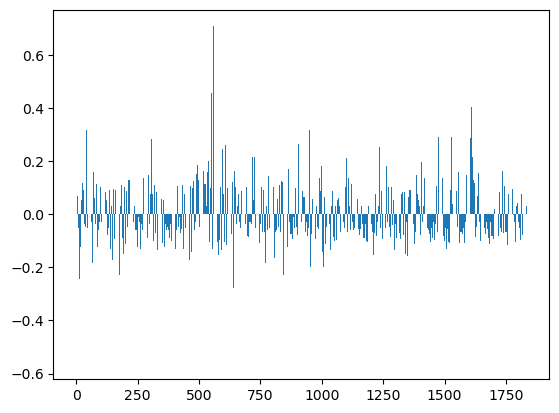

In [89]:
plt.figure()

plt.bar(range(len(logi.coef_.flatten())), logi.coef_.flatten())
plt.show()

In [90]:
# 회귀 모델의 계수를 내림차순으로 정렬
coef_pos_idx = sorted(((value, idx) for idx, value in enumerate(logi.coef_.flatten())), reverse = True)

In [91]:
coef_pos_idx

[(0.7069500358114165, 559),
 (0.6809644567556515, 568),
 (0.6542403688277959, 121),
 (0.5451486296192531, 472),
 (0.5137650612329135, 326),
 (0.45807126991140434, 551),
 (0.40477564934621235, 1610),
 (0.40477564934621235, 374),
 (0.39590978772570357, 1145),
 (0.35439599471037353, 785),
 (0.3518208635068558, 894),
 (0.34884970964825923, 56),
 (0.33615437398181164, 1005),
 (0.31894133032564187, 42),
 (0.3185743012292921, 950),
 (0.3147132535411382, 134),
 (0.31390506580843475, 564),
 (0.2998486331987755, 1487),
 (0.29975920508911036, 1611),
 (0.2942739882414141, 569),
 (0.2912900495185383, 1475),
 (0.2910444538956544, 491),
 (0.2898110903057218, 443),
 (0.28939354269103307, 1528),
 (0.28621960651189493, 1722),
 (0.28621960651189493, 1606),
 (0.28621960651189493, 1411),
 (0.28621960651189493, 1285),
 (0.28621960651189493, 768),
 (0.28621960651189493, 672),
 (0.28621960651189493, 392),
 (0.28621960651189493, 265),
 (0.28414646346674055, 307),
 (0.2831640195139374, 556),
 (0.282333466806498

In [92]:
# 상위 20개 긍정 형태소
for value, idx in coef_pos_idx[:20]:
    print(tfidf.get_feature_names_out()[idx], value)

맛있어요 0.7069500358114165
맛있음 0.6809644567556515
고등어 0.6542403688277959
라자냐 0.5451486296192531
다른 0.5137650612329135
맛있고 0.45807126991140434
추억 0.40477564934621235
대존맛 0.40477564934621235
양이 0.39590978772570357
분위기도 0.35439599471037353
생각나요 0.3518208635068558
간짜장 0.34884970964825923
신촌에 0.33615437398181164
가성비 0.31894133032564187
수제비 0.3185743012292921
공간 0.3147132535411382
맛있었어요 0.31390506580843475
좋네요 0.2998486331987755
추억의 0.29975920508911036
맛있지는 0.2942739882414141


In [93]:
# 상위 20개 부정 형태소
for value, idx in coef_pos_idx[:-20:-1]:
    print(tfidf.get_feature_names_out()[idx], value)

별로 -0.5580463372521015
그냥 -0.42807559917533444
계좌이체 -0.41581889010068945
카드 -0.41581889010068945
맛이변함ㅠㅠ -0.39736240149601254
그리고 -0.37704629758828695
굳이 -0.31777343295683014
돈까스 -0.3053116940530159
만원 -0.3042234970564613
너무 -0.29863948330953494
한식집같아요 -0.29780103482876497
않아요 -0.28837918863309175
음식 -0.2871408269940717
가격은 -0.28676869012937767
가격이면 -0.2809776486864019
광고 -0.2809776486864019
괜찮은집 -0.2809776486864019
말그대로 -0.2809776486864019
뭔들 -0.2809776486864019
